## 📩 Load the `geoJson` file

This blogpost aims at building an hexbin map of US counties. Each county will be represented as a hexagone. The county boundaries are available [here](https://team.carto.com/u/andrew/tables/andrew.us_states_hexgrid/public/map). For your convenience I've uploaded the exact file used in this post on [github](https://github.com/holtzy/The-Python-Graph-Gallery/blob/master/static/data/us_states_hexgrid.geojson.json).

The coordinates are stored at `geoJson` format, probably the most common file format for this kind of information. If you want to know more about this, visit the [background map section](https://python-graph-gallery.com/map) of the gallery that gives a tour on how to build a map with python.

Now, let's load this `geoJson` file from the web with `geopandas`

In [525]:
# Import geopandas library
import geopandas as gpd

# Load file
url = "https://raw.githubusercontent.com/holtzy/The-Python-Graph-Gallery/master/static/data/us_states_hexgrid.geojson.json"
geoData = gpd.read_file(url)


That's it, we now have a geo dataframe containing all the counties as hexagones. Before starting to draw a map with it, you can have a look at it with:

In [526]:
geoData.head(2)

,cartodb_id,created_at,updated_at,label,bees,iso3166_2,google_name,geometry
0,1219,2015-05-13T22:26:15+00:00,2015-10-05T16:00:16+00:00,Maine,60.5,ME,Maine (United States),"POLYGON ((-72.62574 55.31320, -69.90286 54.408..."
1,1217,2015-05-13T22:24:35+00:00,2015-10-05T16:00:16+00:00,R.I.,47.8,RI,Rhode Island (United States),"POLYGON ((-72.62574 49.57439, -69.90286 48.544..."


## 🙇 Basic hexbin map

`GeoPlot` is probably the best python library to build a map from a geo dataframe. It is pretty straightforward thanks to its `polyplot()` function.

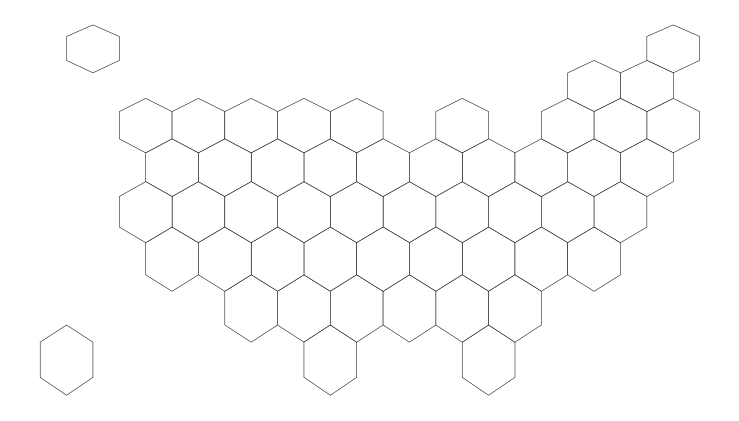

In [527]:
# Import the geoplot library.
import matplotlib.pyplot as plt

# Set the plot size for this notebook:
plt.rcParams["figure.figsize"]=13,13

# Draw a map with matplotlib
geoData.plot(color="white", edgecolor='black', linewidth=.5);
plt.axis('off');

## 🖊️ Add county names

Let's add county names at the centroid of each. Fortunately, centroids are already available from the `geometry` column of the geo dataframe. For instance, you can access it for the first county with `df.head(1).geometry.centroid`.

Let's add a `centroid` column to the original dataframe:

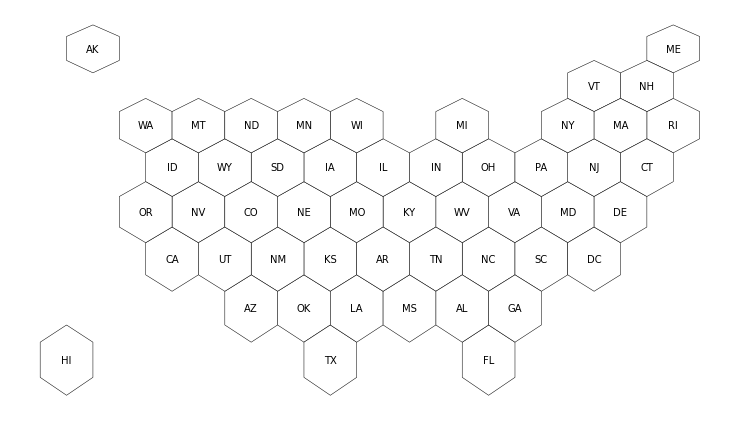

In [528]:
# add a "centroid" column with the centroid position of each county
geoData['centroid'] = geoData['geometry'].apply(lambda x: x.centroid)

# redraw the empty hexbin map:
geoData.plot(color="white", edgecolor='black', linewidth=.5);
plt.axis('off');

# for each county, annotate with the county name located at the centroid coordinates 
for idx, row in geoData.iterrows():
    plt.annotate(s=row['iso3166_2'], xy=row['centroid'].coords[0], horizontalalignment='center', va='center')


Now let's plot both the county borders and their labels at centroids position.

## 🛠️ Load & merge numeric data

Let's transform the useless hexbin map above in a choropleth map, where each county is colored according to its mariage rate (# of mariage per 1000 inhabitants). The dataset is available [here](https://raw.githubusercontent.com/holtzy/The-Python-Graph-Gallery/master/static/data/State_mariage_rate.csv)

In [529]:
# Read the mariage data stored on github:
import pandas as pd
mariageData = pd.read_csv("https://raw.githubusercontent.com/holtzy/The-Python-Graph-Gallery/master/static/data/State_mariage_rate.csv")

# Add a new column to the geo dataframe that will be used for joining:
geoData['state'] = geoData['google_name'].str.replace(' \(United States\)','')

# Merge the mariage dataset with the geospatial information
geoData = geoData.set_index('state').join(mariageData.set_index('state'))


It is now possible to create a first choropleth map as follow:

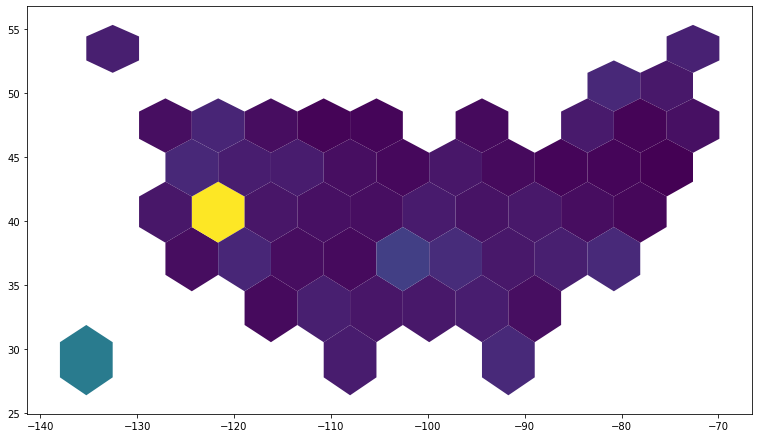

In [530]:
geoData.plot(column="y_2015", cmap="viridis");

## ✨ Final map

Let's add the final touch to make it look good. Title, annotation, better color scale and more:

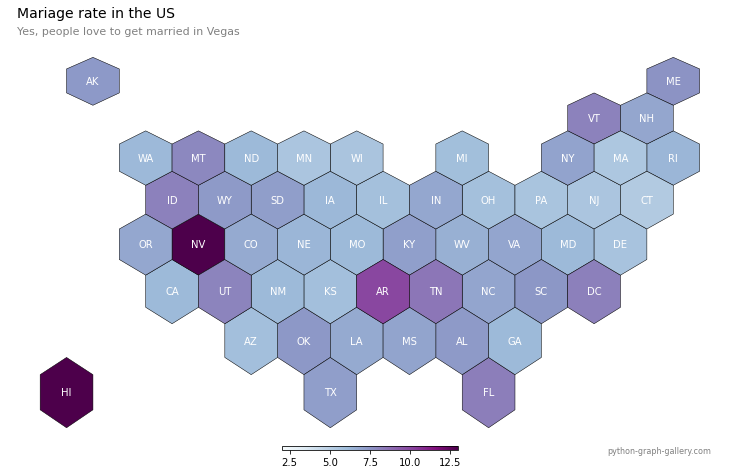

In [531]:
# Initialize the figure
fig, ax = plt.subplots(1, figsize=(13, 13))

# map counties with the right color:
geoData.plot(
    ax=ax,
    column="y_2015", 
    cmap="BuPu", 
    norm=plt.Normalize(vmin=2, vmax=13),
    edgecolor='black', 
    linewidth=.5
);

# Remove useless axis
ax.axis('off');

# Add title, subtitle and author
ax.annotate('Mariage rate in the US', xy=(10,440),  xycoords='axes pixels', horizontalalignment='left', verticalalignment='top', fontsize=14, color='black')
ax.annotate('Yes, people love to get married in Vegas', xy=(10,420),  xycoords='axes pixels', horizontalalignment='left', verticalalignment='top', fontsize=11, color='#808080')
ax.annotate('python-graph-gallery.com', xy=(600,0),  xycoords='axes pixels', horizontalalignment='left', verticalalignment='top', fontsize=8, color='#808080')

# for each county, annotate with the county name located at the centroid coordinates 
for idx, row in geoData.iterrows():
    ax.annotate(
        s=row['iso3166_2'], 
        xy=row['centroid'].coords[0], 
        horizontalalignment='center', 
        va='center',
        color="white"
    )

# Add a color bar
sm = plt.cm.ScalarMappable(cmap='BuPu', norm=plt.Normalize(vmin=2, vmax=13))
fig.colorbar(sm, orientation="horizontal", aspect=50, fraction=0.005, pad=0 );


Note: there are still some stuff that could be improved here but it's getting late 😴 